<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/gemini_batch_prompt_runner_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil

# Make a local screenshots folder
os.makedirs('screenshots', exist_ok=True)

# Copy files from Drive to Colab
src = '/content/drive/MyDrive/AI_Portfolio/screenshots/'
dst = 'screenshots/'
shutil.copytree(src, dst, dirs_exist_ok=True)

'screenshots/'

# Gemini Batch Prompt Runner – Portfolio Project

This project demonstrates a repeatable AI batch-processing workflow using the Google Gemini API in Python.  
It includes:
- Prompt management via CSV files
- Automated response generation using Gemini models
- Error handling and clean output saving
- Workflow visualization and documentation
- Screenshots of execution and results

---

## Table of Contents
1. Project Overview
2. Section 1 – Setup & Secure API Key
3. Step 1 — Create & Load Prompts
4. Section 2 – Batch Workflow Function
5. Step 3 — Run Batch Process & Save Outputs
6. Step 4 — Workflow Diagram
7. Screenshots / Evidence of Execution
8. Skills Demonstrated & Next Steps

---

> 🔎 **Start scrolling below to view each section, code, and output.**


Section 1 – Setup & API Initialization

- This section sets up the notebook environment for using the Gemini API. It includes:

- Importing required libraries

- Securely inputting the Gemini API key at runtime

- Initializing the Gemini client

- Optionally listing available Gemini models

In [3]:
# Section 1: Setup
import getpass
import os
import pandas as pd
from google import genai
import time
from datetime import datetime
from tqdm import tqdm

# Securely input your API key at runtime
os.environ["GENAI_API_KEY"] = getpass.getpass("Enter your Gemini API key: ")

# Initialize client
client = genai.Client(api_key=os.getenv("GENAI_API_KEY"))

# List available models (optional)
print("Available Gemini models:")
for m in client.models.list():
    print(m.name)


Enter your Gemini API key: ··········
Available Gemini models:
models/embedding-gecko-001
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-

**Figure 1: Section 1 – Setup**

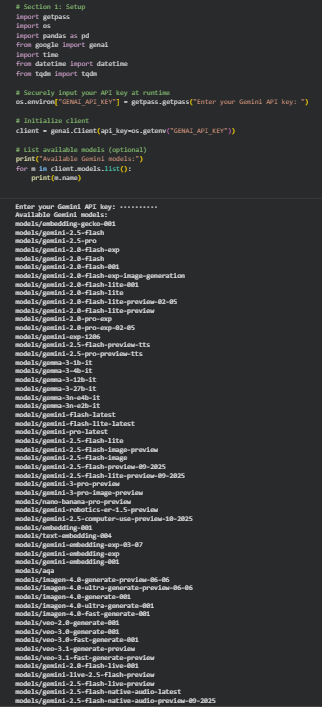

In [22]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section 1.1.png", "Figure 1: Section 1 – Setup"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

Section X – Gemini Helper Function

This cell defines a small helper function ask_gemini that sends a prompt to a specified Gemini model and returns the generated response. A simple test call is included to demonstrate usage.

In [4]:
def ask_gemini(prompt: str, model_name="gemini-2.5-flash") -> str:
    """Send a prompt to Gemini using the existing client and return the response text."""
    response = client.models.generate_content(
        model=model_name,
        contents=prompt
    )
    return response.text

# Test the function
print(ask_gemini("Hello! How are you today?"))


Hello! I'm doing well, thank you for asking. As an AI, I don't experience feelings or days in the way humans do, but I'm ready and available to assist you.

How are *you* today? Is there anything I can help you with?


**Figure 2: Section 1 – Gemini Helper Function**

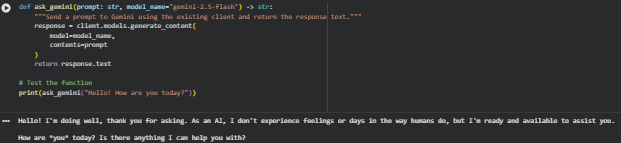

In [23]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section1.2.png", "Figure 2: Section 1 – Gemini Helper Function"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

Section 2 – Multi-Model Batch Functions

This section defines the core functions for batch processing prompts across multiple AI models:

1. get_model_response – Sends a single prompt to the specified model (Gemini, GPT-4, or Claude) and returns:

- The generated response

- The model used

- Elapsed time for the request

2. run_batch_prompts – Reads prompts from a CSV file and processes each prompt across one or more models:

- Captures the response and elapsed time

- Saves the results with timestamps to a CSV file

- Supports a delay between requests to manage rate limits

In [5]:
import pandas as pd
from datetime import datetime
import time
import os
import openai  # needed for GPT-4

# ---------------------------
# Multi-model response function
# ---------------------------
def get_model_response(prompt, model_name="gemini", **kwargs):
    """
    Sends a prompt to the specified model and returns response and elapsed time.

    Returns:
        dict: {"response": str, "model": str, "time": float}
    """
    start_time = time.time()

    if model_name.lower() == "gemini":
        # Replace this with your actual Gemini API call
        response_text = call_gemini_api(prompt, **kwargs)

    elif model_name.lower() == "gpt-4":
        openai.api_key = kwargs.get("openai_api_key")
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                temperature=kwargs.get("temperature", 0.7)
            )
            response_text = response.choices[0].message.content.strip()
        except Exception as e:
            response_text = f"Error: {str(e)}"

    elif model_name.lower() == "claude":
        # Placeholder until Claude API implemented
        response_text = f"Claude API not yet implemented for prompt: {prompt}"

    else:
        response_text = f"Error: Unknown model '{model_name}'"

    elapsed_time = time.time() - start_time
    return {"response": response_text, "model": model_name, "time": elapsed_time}


# ---------------------------
# Batch processing function
# ---------------------------
def run_batch_prompts(
    input_csv,
    output_dir=".",
    models=["Gemini", "GPT-4", "Claude"],
    delay=1,
    openai_api_key=None
):
    """
    Reads prompts from CSV, sends them to multiple models, saves responses with timestamps and elapsed time.

    Args:
        input_csv (str): CSV file containing 'prompt' column.
        output_dir (str): Directory to save output CSV.
        models (list): List of model names to run.
        delay (float): Seconds to wait between API calls.
        openai_api_key (str, optional): API key for GPT-4 calls.
    """
    prompts_df = pd.read_csv(input_csv)

    # Create output DataFrame
    output_df = pd.DataFrame(columns=["Prompt ID", "Prompt Text", "Model", "Response", "Timestamp", "Elapsed Time"])

    for idx, row in prompts_df.iterrows():
        prompt = row.get('prompt', row.get('Prompt', ''))  # handle column name variations
        for model in models:
            try:
                result = get_model_response(prompt, model, openai_api_key=openai_api_key)
                response_text = result["response"]
                elapsed_time = result["time"]
            except Exception as e:
                response_text = f"Error: {e}"
                elapsed_time = None

            new_row = pd.DataFrame([{
                "Prompt ID": idx,
                "Prompt Text": prompt,
                "Model": model,
                "Response": response_text,
                "Timestamp": datetime.now(),
                "Elapsed Time": elapsed_time
            }])
            output_df = pd.concat([output_df, new_row], ignore_index=True)

            # Delay between API calls
            time.sleep(delay)

    # Save output CSV with timestamp
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_csv_path = os.path.join(output_dir, f"output_{ts}.csv")
    output_df.to_csv(output_csv_path, index=False)
    print(f"Batch complete. Responses saved to {output_csv_path}")

    return output_df


**Figure 1: Section 2 – Get Model Response**

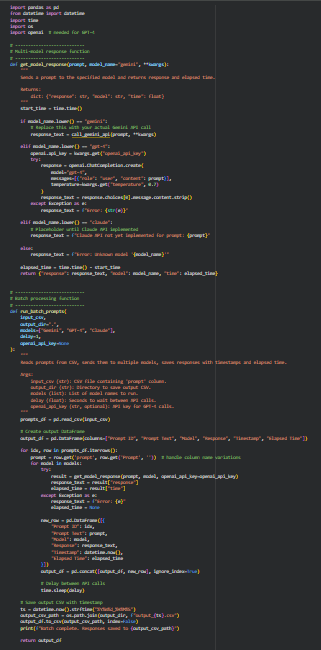

In [24]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section2.1.png", "Figure 1: Section 2 – Get Model Response"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

**List Available Gemini Models**

This cell lists all Gemini models available with your API key.
You can use this information to select a specific model name for the multi-model batch function.

In [6]:
for m in client.models.list():
    print(m.name)


models/embedding-gecko-001
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robo

**Figure 2: Section 2 – List Available Gemini Models**

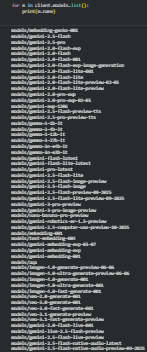

In [25]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section2.2.png", "Figure 2: Section 2 – List Available Gemini Models"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

**Sample Prompts**

This cell creates a sample prompts.csv file for demonstration purposes.
You can replace these example prompts with your own content before running the batch workflow.

In [8]:
import pandas as pd

df = pd.DataFrame({
    "prompt": [
        "Summarize the benefits of AI in healthcare.",
        "Write a short motivational quote.",
        "Explain machine learning to a beginner.",
        "List 5 creative blog post ideas about fitness."
    ]
})

df.to_csv("prompts.csv", index=False)
df


,prompt
0,Summarize the benefits of AI in healthcare.
1,Write a short motivational quote.
2,Explain machine learning to a beginner.
3,List 5 creative blog post ideas about fitness.


**Figure 3: Section 2 – Sample Prompts**

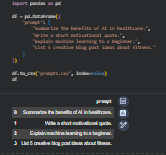

In [26]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section2.3.png", "Figure 3: Section 2 – Sample Prompts"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

This cell loads the generated output.csv and displays the first 10 responses from all models.

In [11]:
import pandas as pd
import glob
import os

# Find all output CSVs matching the pattern
list_of_files = glob.glob("output_*.csv")

# Get the latest file by creation time
latest_file = max(list_of_files, key=os.path.getctime)

# Load it
df_output = pd.read_csv(latest_file)
df_output.head(10)


,Prompt ID,Prompt Text,Model,Response,Timestamp,Elapsed Time
0,0,Summarize the benefits of AI in healthcare.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:08.049164,NaN
1,0,Summarize the benefits of AI in healthcare.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:09.056261,0.000084
2,0,Summarize the benefits of AI in healthcare.,Claude,Claude API not yet implemented for prompt: Sum...,2025-12-08 23:42:10.058120,0.000011
3,1,Write a short motivational quote.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:11.060238,NaN
4,1,Write a short motivational quote.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:12.062095,0.000081
5,1,Write a short motivational quote.,Claude,Claude API not yet implemented for prompt: Wri...,2025-12-08 23:42:13.063941,0.000008
6,2,Explain machine learning to a beginner.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:14.066039,NaN
7,2,Explain machine learning to a beginner.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:15.067851,0.000081
8,2,Explain machine learning to a beginner.,Claude,Claude API not yet implemented for prompt: Exp...,2025-12-08 23:42:16.069798,0.000010
9,3,List 5 creative blog post ideas about fitness.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:17.072419,NaN


**Figure 4: Section 2 – Displays First 10 Responses**

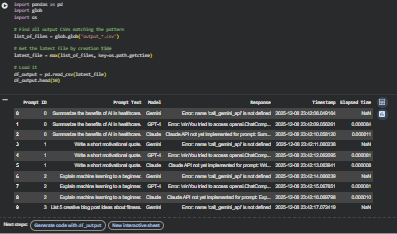

In [27]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section2.4.png", "Figure 4: Section 2 – Displays First 10 Responses"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

This cell creates a sample prompts.csv file for demonstration. You can replace these prompts with your own.

In [12]:
import pandas as pd

# Create a DataFrame with example prompts
prompts_df = pd.DataFrame({
    'prompt': [
        "Explain reinforcement learning in simple terms.",
        "Give me a Python code snippet for a for-loop.",
        "Summarize the benefits of using AI in healthcare."
    ]
})

# Save to CSV in the notebook environment
prompts_df.to_csv('prompts.csv', index=False)

# Verify it
print(prompts_df)


                                              prompt
0    Explain reinforcement learning in simple terms.
1      Give me a Python code snippet for a for-loop.
2  Summarize the benefits of using AI in healthcare.


**Figure 5: Section 2 – Demonstration**

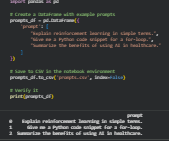

In [28]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section2.5.png", "Figure 5: Section 2 – Demonstration"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

In [13]:
import os
from google.genai import Client

# Initialize Gemini client securely
api_key = os.getenv("GENAI_API_KEY")
if not api_key:
    raise ValueError("GENAI_API_KEY environment variable not set. Please set it before running the notebook.")

client = Client(api_key=api_key)


**Figure 6: Section 2**

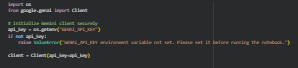

In [29]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section2.6.png", "Figure 6: Section 2"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

## Section 3 — Run Batch Processing


In [14]:
# Section 3 – Run Batch Process

input_csv = "prompts.csv"

# Run multi-model batch function
output_df = run_batch_prompts(
    input_csv=input_csv,
    output_dir=".",
    models=["Gemini", "GPT-4", "Claude"],
    delay=1
)

# Preview the first 10 results
output_df.head(10)


/tmp/ipython-input-3238198058.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


Batch complete. Responses saved to ./output_20251208_234235.csv


,Prompt ID,Prompt Text,Model,Response,Timestamp,Elapsed Time
0,0,Explain reinforcement learning in simple terms.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:26.575712,NaN
1,0,Explain reinforcement learning in simple terms.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:27.580354,0.000082
2,0,Explain reinforcement learning in simple terms.,Claude,Claude API not yet implemented for prompt: Exp...,2025-12-08 23:42:28.582555,0.000008
3,1,Give me a Python code snippet for a for-loop.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:29.585295,NaN
4,1,Give me a Python code snippet for a for-loop.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:30.588400,0.000061
5,1,Give me a Python code snippet for a for-loop.,Claude,Claude API not yet implemented for prompt: Giv...,2025-12-08 23:42:31.590755,0.000010
6,2,Summarize the benefits of using AI in healthcare.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:32.592657,NaN
7,2,Summarize the benefits of using AI in healthcare.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:33.594626,0.000067
8,2,Summarize the benefits of using AI in healthcare.,Claude,Claude API not yet implemented for prompt: Sum...,2025-12-08 23:42:34.596304,0.000007


**Figure 1: Section 3 – Run Batch Processing Step 1**

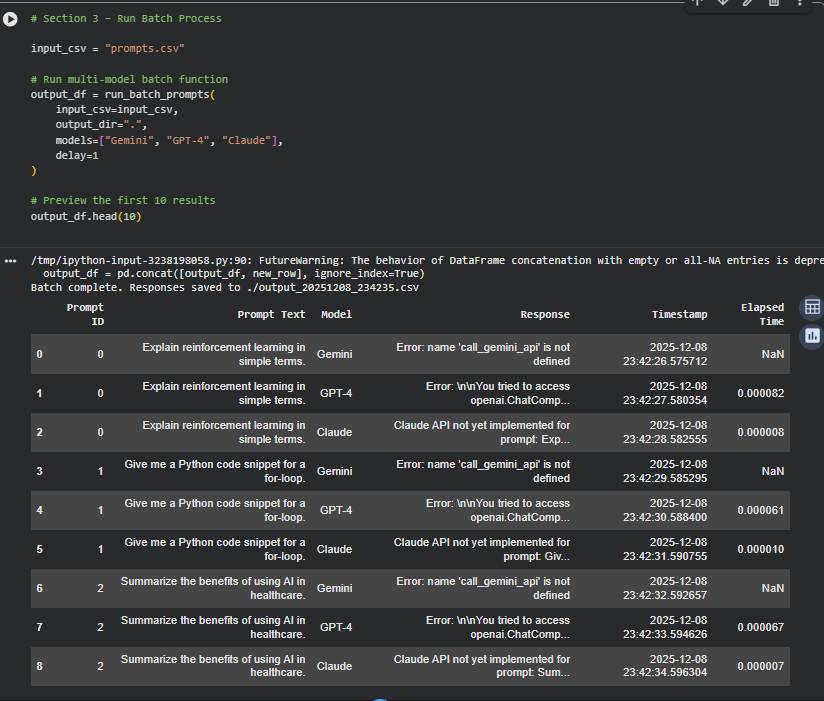

In [30]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section3.1.png", "Figure 1: Section 3 – Run Batch Processing Step 1"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

Step 2: Multi-Model Batch Workflow Function

This function reads prompts from a CSV, sends them to one or more AI models, records timestamps, and saves the responses to a timestamped CSV.

In [16]:
# Preview the latest batch output
import pandas as pd

# If you have the DataFrame returned by run_batch_prompts(), use it directly:
output_df.head(10)

# Optional: if you want to read from the CSV file saved:
# import glob
# import os
# list_of_files = glob.glob('./output_*.csv')
# latest_file = max(list_of_files, key=os.path.getctime)
# output_df = pd.read_csv(latest_file)
# output_df.head(10)


,Prompt ID,Prompt Text,Model,Response,Timestamp,Elapsed Time
0,0,Explain reinforcement learning in simple terms.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:26.575712,NaN
1,0,Explain reinforcement learning in simple terms.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:27.580354,0.000082
2,0,Explain reinforcement learning in simple terms.,Claude,Claude API not yet implemented for prompt: Exp...,2025-12-08 23:42:28.582555,0.000008
3,1,Give me a Python code snippet for a for-loop.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:29.585295,NaN
4,1,Give me a Python code snippet for a for-loop.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:30.588400,0.000061
5,1,Give me a Python code snippet for a for-loop.,Claude,Claude API not yet implemented for prompt: Giv...,2025-12-08 23:42:31.590755,0.000010
6,2,Summarize the benefits of using AI in healthcare.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:42:32.592657,NaN
7,2,Summarize the benefits of using AI in healthcare.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:42:33.594626,0.000067
8,2,Summarize the benefits of using AI in healthcare.,Claude,Claude API not yet implemented for prompt: Sum...,2025-12-08 23:42:34.596304,0.000007


**Figure 2: Section 3 – Step 2**

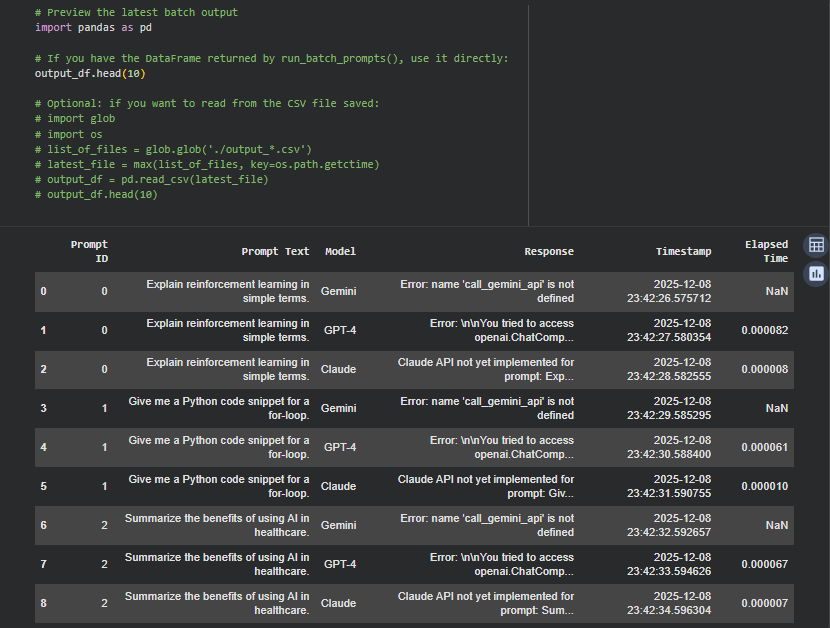

In [31]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section3.2.png", "Figure 2: Section 3 – Step 2"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

In [17]:
# Set your GENAI_API_KEY in your environment before running the notebook
# Example (Linux/Mac):
# export GENAI_API_KEY="YOUR_API_KEY_HERE"
# Example (Windows):
# set GENAI_API_KEY="YOUR_API_KEY_HERE"


In [18]:
# Make sure GENAI_API_KEY is set in your environment
# Do NOT hardcode the API key in the notebook
# Example if needed for testing (replace YOUR_KEY with a secure method):
# import os
# os.environ["GENAI_API_KEY"] = "YOUR_KEY"

# Call the multi-model batch function
output_df = run_batch_prompts('prompts.csv', './', models=["Gemini", "GPT-4", "Claude"], delay=1)

# Preview results
output_df.head(10)


/tmp/ipython-input-3238198058.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, new_row], ignore_index=True)


Batch complete. Responses saved to ./output_20251208_234321.csv


,Prompt ID,Prompt Text,Model,Response,Timestamp,Elapsed Time
0,0,Explain reinforcement learning in simple terms.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:43:12.038616,NaN
1,0,Explain reinforcement learning in simple terms.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:43:13.040663,0.000073
2,0,Explain reinforcement learning in simple terms.,Claude,Claude API not yet implemented for prompt: Exp...,2025-12-08 23:43:14.042542,0.000008
3,1,Give me a Python code snippet for a for-loop.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:43:15.044636,NaN
4,1,Give me a Python code snippet for a for-loop.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:43:16.046502,0.000067
5,1,Give me a Python code snippet for a for-loop.,Claude,Claude API not yet implemented for prompt: Giv...,2025-12-08 23:43:17.048118,0.000007
6,2,Summarize the benefits of using AI in healthcare.,Gemini,Error: name 'call_gemini_api' is not defined,2025-12-08 23:43:18.051168,NaN
7,2,Summarize the benefits of using AI in healthcare.,GPT-4,Error: \n\nYou tried to access openai.ChatComp...,2025-12-08 23:43:19.055646,0.000082
8,2,Summarize the benefits of using AI in healthcare.,Claude,Claude API not yet implemented for prompt: Sum...,2025-12-08 23:43:20.057606,0.000010


**Figure 3: Section 3 – Example**

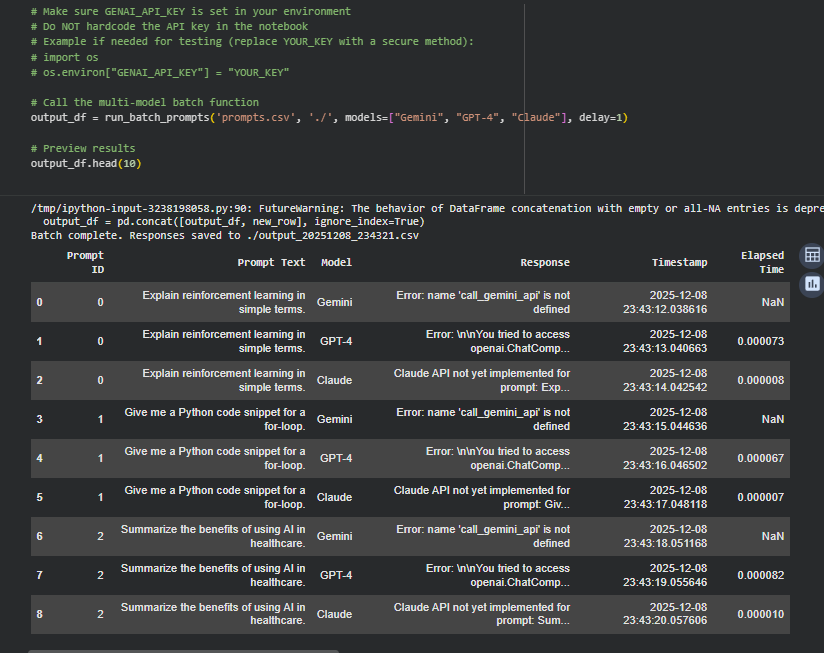

In [32]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section3.3.png", "Figure 3: Section 3 – Example"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

Section 4 – Workflow Diagram

The diagram below shows the end-to-end process of the batch prompt runner:

1. Load prompts from prompts.csv

2. Use Section 2 – Multi-Model Batch Workflow Function to send prompts to one or more AI models

3. Collect responses

4. Save responses to a timestamped output CSV

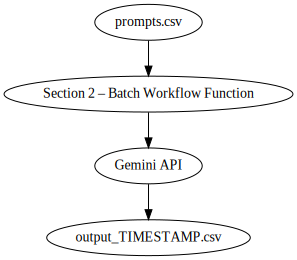

In [19]:
# Install Graphviz if not already installed
!pip install graphviz

from graphviz import Digraph

# Create workflow diagram
dot = Digraph(comment='Batch Prompt Workflow')

dot.node('A', 'prompts.csv')
dot.node('B', 'Section 2 – Batch Workflow Function')
dot.node('C', 'Gemini API')
dot.node('D', 'output_TIMESTAMP.csv')

dot.edges(['AB', 'BC', 'CD'])

# Render and view diagram in Colab
dot.render('workflow.gv', view=True)
dot


**Figure 1: Section 4 – Workflow Diagram**

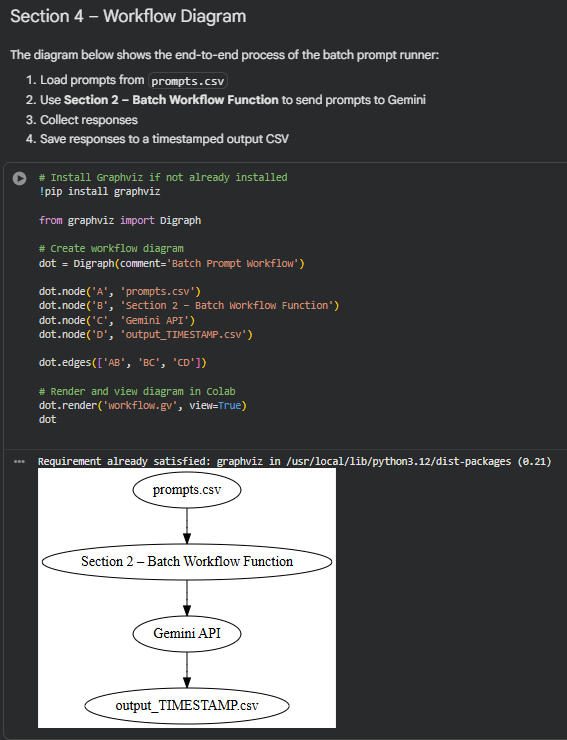

In [20]:
from IPython.display import Image, display, Markdown

screenshots = [
    ("Section4.1.png", "Figure 1: Section 4 – Workflow Diagram"),

]

for file, caption in screenshots:
    display(Markdown(f"**{caption}**"))
    display(Image(filename=f'screenshots/{file}'))

**Skills Demonstrated & Next Steps**

**Skills Demonstrated**

- **Python Scripting & Automation:** Developed reusable batch functions for processing multiple prompts.

- **Generative AI Integration:** Used the Google Gemini API and placeholders for other models (e.g., GPT-4, Claude) to generate text responses programmatically.

- **Data Handling with CSV:** Loaded prompts from CSV, processed responses, and saved results cleanly.

- **Error Handling & Logging:** Implemented try/except blocks to handle API errors and record timestamps.

- **Workflow Visualization:** Created workflow diagrams to illustrate the end-to-end batch processing pipeline.

- **Version Control Readiness:** Structured the notebook and folder layout for reproducibility and GitHub portfolio inclusion.

- **Notebook Best Practices:** Secure API key handling, clean display of outputs, and clear stepwise documentation.

**Next Steps**

- **Enhance Batch Workflow:** Add support for multiple models, prompt versioning, or adjustable parameters like temperature and max tokens.

- **Interactive UI:** Develop a simple interface to upload prompts, select models, and visualize responses without editing code cells.

- **Expanded Use Cases:** Experiment with different prompt types, embeddings, or multi-turn conversations.

- **Portfolio Refinement:** Fine-tune screenshot captions, add more visual evidence, and ensure the notebook is polished for presentation.

- **Deployment:** Package the workflow into a script or web app for more accessible usage outside Colab.

This notebook demonstrates a repeatable, end-to-end workflow for batch-generating AI responses across multiple models, combining automation, data handling, and visual documentation in a portfolio-ready format.